# Testing code on simulated data.

In [54]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from astropy.io import fits
from astropy.table import Table
from isochrones.mist import MIST_Isochrone
from isochrones import StarModel
import emcee
import priors
import corner
import h5py
import tqdm

Combine isochrones.py with a gyro model to get ages.

In [43]:
# Set up the stuff needed by isochrones.py

mist = MIST_Isochrone()

def setup(obs, gyro_only=False, iso_only=False):
    
    # Set the initial values
    mass_init = 1
    age_init = 2e9
    feh_init = 0
    distance_init = .3
    Av_init = .1

    # sample in ln(mass), log10(age) and ln(distance).
    p_init = np.array([np.log(mass_init), np.log10(age_init), feh_init, np.log(distance_init), Av_init])

    # Set up the StarModel object needed to calculate the likelihood. 
    param_dict = {"J": (obs.jmag, obs.jmag_err),
                  "H": (obs.hmag, obs.hmag_err),
                  "K": (obs.kmag, obs.kmag_err),
                  "teff": (obs.teff, obs.teff_err),
                  "logg": (obs.logg, obs.logg_err),
                  "feh": (obs.feh, obs.feh_err),
                  "parallax": (obs.parallax, obs.parallax_err)
                 }  # Isochrones.py takes milliarcseconds

    mod = StarModel(mist, **param_dict)
    
    args = [mod, obs.prot, obs.prot_err, obs.BV, gyro_only, iso_only]
    
    return mod, param_dict, p_init, args

Define the gyrochronology model. I'm using the Barnes (2003) functional form with my (2015) parameters.

In [57]:
def gyro_model(log10_age, bv):
    """
    Given a B-V colour and an age, predict a rotation period.
    Returns log(age) in Myr.
    parameters:
    ----------
    logage: (array)
        The log age of a star: log10(age) in years.
    bv: (array)
        The B-V colour of a star.
    """
    age_myr = (10**log10_age)*1e-6
    
    a, b, c, n = [.4, .31, .45, .55]
    
    log_P = n*np.log10(age_myr) + np.log10(a) + b*np.log10(bv-c)
    return 10**log_P

Define the log prior and the log posterior functions.

In [19]:
def lnprior(params):
    """
    lnprior on all parameters.
    params need to be linear except age which is log10(age [yr]).
    """
    
    # log Priors over age, metallicity and distance. (The priors in priors.py are not in log)
    age_prior = np.log(priors.age_prior(params[1]))
    feh_prior = np.log(priors.feh_prior(params[2]))
    distance_prior = np.log(priors.distance_prior(np.exp(params[3])))

    # Uniform prior on extinction.
    mAv = (0 <= params[4]) * (params[4] < 1)  # Prior on A_v
    mAv = mAv == 1
    
    # Uniform prior on mass
    m = (-20 < params[0]) * (params[0]) < 20  # Broad bounds on mass.
            
    if mAv and m and np.isfinite(age_prior) and np.isfinite(distance_prior):
        return age_prior + feh_prior + distance_prior
    
    else:
        return -np.inf

    
def lnprob(lnparams, *args):
    # Transform mass and distance back to linear.
    params = lnparams*1
    params[0] = np.exp(lnparams[0])
    params[3] = np.exp(lnparams[3])
    
    mod, period, period_err, bv_est, gyro_only, iso_only = args
    
    B = mist.mag["B"](*params)
    V = mist.mag["V"](*params)
    bv = B-V
    
    # If the prior is -inf, don't even try to calculate the isochronal likelihood.
    lnpr = lnprior(params)
    if lnpr == -np.inf:
        return lnpr
    
    else:
    
        if iso_only:
            return mod.lnlike(params) + lnpr
        
        else:
            if bv > .45:
                gyro_lnlike = -.5*((period - gyro_model(params[1], bv)) /period_err)**2
            else:
                gyro_lnlike = 0
    
        # B-V is estimated from mass, etc, so you need to use a different B-V estimate if gyro_only.
        if gyro_only:
            return -.5*((period - gyro_model(params[1], bv_est)) /period_err)**2 + lnpr
    
        else:
            return mod.lnlike(params) + gyro_lnlike + lnpr

Run the MCMC.

In [73]:
def run_mcmc(obs, args, p_init, ndim=5, nwalkers=24):
    
    p0 = [p_init + np.random.randn(ndim)*1e-4 for k in range(nwalkers)]

    print("Burning in...")
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=args)
#     for p0, lnp, state in tqdm.tqdm(sampler.sample(p0, iterations=5000)):
#         pass
    p0, lnp, state = sampler.run_mcmc(p0, 5000)
        
    print("Production run...")
    sampler.reset()
    p0, lnp, state = sampler.run_mcmc(p0, 10000)

#     for p, lnp, state in tqdm.tqdm(sampler.sample(p0, iterations=10000)):
#         pass
    
    return sampler


def make_plots(sampler, i, savedir):
    ndim = 5
    
    print("Plotting production chains...")
    for j in range(ndim):
        plt.subplot(ndim, 1, j+1)
        plt.plot(sampler.chain[:, :, j].T, "k", alpha=.1)
        plt.savefig("{0}/{1}_chains".format(savedir, i))
        plt.close()
    
    print("Making corner plot...")
    samples = sampler.flatchain
    samples[:, 0] = np.exp(samples[:, 0])
    samples[:, 3] = np.exp(samples[:, 3])
    samples[:, 1] = (10**samples[:, 1])*1e-9
    
    labels = ["mass [M_sun]", "log10(age [yr])", "[Fe/H]", "distance [pc]", "A_v"]
    corner.corner(samples, labels=labels);
    plt.savefig("{0}/{1}_corner".format(savedir, i))
    plt.close()
    
    print("Plotting age posterior")
    age_gyr = samples[:, 1]
    plt.hist(age_gyr)
    plt.xlabel("Age [Gyr]")
    med, std = np.median(age_gyr), np.std(age_gyr)
    print("age = ", med, "+/-", std)
    plt.axvline(med, color="k")
    plt.axvline(med - std, color="k", linestyle="--")
    plt.axvline(med + std, color="k", linestyle="--")
    plt.savefig("{0}/{1}_marginal_age".format(savedir, i))
    plt.close()
    print("age = ", med)

Load the simulated data file.

In [20]:
df = pd.read_csv("simulated_data.csv")

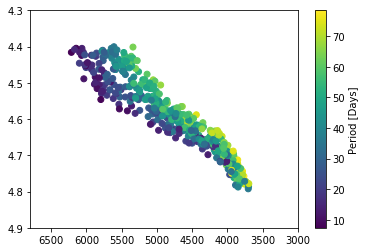

In [21]:
plt.scatter(df.teff, df.logg, c=df.prot)
plt.ylim(4.9, 4.3)
plt.xlim(6800, 3000)
plt.colorbar(label="Period [Days]")

Perturb the true parameters with some amount of noise.

In [28]:
teff_err = 1  # Kelvin
logg_err = .001  # dex
feh_err = .001  # dex
jmag_err = .001 # mags
hmag_err = .001  # mags
kmag_err = .001  # mags
parallax_err = .00001  # milliarcseconds
prot_err = .01  # Days
BV_err = .001  # mags

teff = df.teff.values + np.random.randn()*teff_err
logg = df.logg.values + np.random.randn()*logg_err
feh = df.feh.values + np.random.randn()*feh_err
jmag = df.J.values + np.random.randn()*jmag_err
hmag = df.H.values + np.random.randn()*hmag_err
kmag = df.K.values + np.random.randn()*kmag_err
parallax = df.parallax.values + np.random.randn()*parallax_err
prot = df.prot.values + np.random.randn()*prot_err
BV = df.B_V.values + np.random.randn()*BV_err

Create a dataframe from the observed data.

In [36]:
obs = pd.DataFrame(dict({"teff": teff, "teff_err": teff_err,
                         "logg": logg, "logg_err": logg_err,
                         "feh": feh, "feh_err": feh_err, 
                         "jmag": jmag, "jmag_err": jmag_err,
                         "hmag": hmag, "hmag_err": hmag_err,
                         "kmag": kmag, "kmag_err": kmag_err,
                         "parallax": parallax, "parallax_err": parallax_err, 
                         "prot": prot, "prot_err": prot_err,
                         "BV": BV, "BV_err": BV_err}))

In [44]:
mod, param_dict, p_init, args = setup(obs.iloc[0], gyro_only=False, iso_only=False)

Loop over stars.

In [ ]:
gyro_only, iso_only = False, False

N = len(df)
for i in tqdm.tqdm(range(N)):
    print(i, "of", N)
    
    mod, param_dict, p_init, args = setup(obs.iloc[i], gyro_only=gyro_only, iso_only=iso_only)
    sampler = run_mcmc(obs.iloc[i], args, p_init)
    
    savedir = "simulation_results/iso_and_gyro"
    
    # Make the plots
    make_plots(sampler, i, savedir)
    
    # Save the samples
    samples = sampler.flatchain
    samples[:, 0] = np.exp(samples[:, 0])
    samples[:, 3] = np.exp(samples[:, 3])
    samples[:, 1] = 10**samples[:, 1]*1e-9
    
    print("Saving samples...")
    with h5py.File("{0}/{1}.h5".format(savedir, i), "w") as f:
        data = f.create_dataset("samples", np.shape(samples))
        data[:, :] = samples




  0%|          | 0/456 [00:00<?, ?it/s]

0 of 456
Burning in...


/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log
/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: overflow encountered in exp
/Users/ruthangus/projects/habitablezoning/code/priors.py:34: RuntimeWarning: overflow encountered in double_scalars
  return 3/max_distance**3 * distance**2




Production run...
Plotting production chains...
Making corner plot...




  0%|          | 1/456 [01:08<8:38:08, 68.33s/it]

Plotting age posterior
age =  0.35481347100754723 +/- 2.7458520352430846
age =  0.35481347100754723
Saving samples...
1 of 456
Burning in...


Production run...
Plotting production chains...
Making corner plot...




  0%|          | 2/456 [02:29<9:05:19, 72.07s/it]

Plotting age posterior
age =  1.775451946805943 +/- 0.40454963207982186
age =  1.775451946805943
Saving samples...
2 of 456
Burning in...


Production run...
Plotting production chains...
Making corner plot...




  1%|          | 3/456 [03:45<9:14:59, 73.51s/it]

Plotting age posterior
age =  0.31372478941495824 +/- 0.27592909088856066
age =  0.31372478941495824
Saving samples...
3 of 456
Burning in...


Production run...
Plotting production chains...
Making corner plot...




  1%|          | 4/456 [05:04<9:24:07, 74.88s/it]

Plotting age posterior
age =  0.12586759694220195 +/- 0.013217655928698304
age =  0.12586759694220195
Saving samples...
4 of 456
Burning in...


Production run...
Plotting production chains...
Making corner plot...




  1%|          | 5/456 [06:40<10:11:05, 81.30s/it]

Plotting age posterior
age =  0.1985715453987517 +/- 0.6930440225667623
age =  0.1985715453987517
Saving samples...
5 of 456
Burning in...


Production run...
Plotting production chains...
Making corner plot...




  1%|▏         | 6/456 [07:53<9:50:42, 78.76s/it] 

Plotting age posterior
age =  3.431529116471007 +/- 1.6641087894226514
age =  3.431529116471007
Saving samples...
6 of 456
Burning in...


Production run...
Plotting production chains...
Making corner plot...




  2%|▏         | 7/456 [09:10<9:46:22, 78.36s/it]

Plotting age posterior
age =  0.1656282446048369 +/- 0.3099664836617341
age =  0.1656282446048369
Saving samples...
7 of 456
Burning in...


Production run...
Plotting production chains...
Making corner plot...




  2%|▏         | 8/456 [10:32<9:53:15, 79.45s/it]

Plotting age posterior
age =  0.12666948090779293 +/- 0.36895921636053164
age =  0.12666948090779293
Saving samples...
8 of 456
Burning in...


Production run...
Plotting production chains...
Making corner plot...




  2%|▏         | 9/456 [11:51<9:50:42, 79.29s/it]

Plotting age posterior
age =  0.9461016207029286 +/- 1.0438000965517096
age =  0.9461016207029286
Saving samples...
9 of 456
Burning in...


Production run...
Plotting production chains...
Making corner plot...




  2%|▏         | 10/456 [13:11<9:50:43, 79.47s/it]

Plotting age posterior
age =  3.1148729344539454 +/- 2.504986432355513
age =  3.1148729344539454
Saving samples...
10 of 456
Burning in...


Production run...
Plotting production chains...
Making corner plot...




  2%|▏         | 11/456 [14:31<9:51:46, 79.79s/it]

Plotting age posterior
age =  0.1765629743193502 +/- 0.03790876395138409
age =  0.1765629743193502
Saving samples...
11 of 456
Burning in...


Production run...
Plotting production chains...
Making corner plot...




  3%|▎         | 12/456 [15:50<9:47:48, 79.43s/it]

Plotting age posterior
age =  1.1978579063417467 +/- 2.3713605852925475
age =  1.1978579063417467
Saving samples...
12 of 456
Burning in...


Production run...
Plotting production chains...
Making corner plot...




  3%|▎         | 13/456 [17:12<9:51:05, 80.06s/it]

Plotting age posterior
age =  0.1257430826255733 +/- 0.011645943701049325
age =  0.1257430826255733
Saving samples...
13 of 456
Burning in...


Production run...
Plotting production chains...
Making corner plot...




  3%|▎         | 14/456 [18:28<9:42:28, 79.07s/it]

Plotting age posterior
age =  0.16089797156638397 +/- 0.025920125257045974
age =  0.16089797156638397
Saving samples...
14 of 456
Burning in...


Production run...
Plotting production chains...
Making corner plot...




  3%|▎         | 15/456 [19:49<9:44:20, 79.50s/it]

Plotting age posterior
age =  0.5670519074837634 +/- 0.530665352150616
age =  0.5670519074837634
Saving samples...
15 of 456
Burning in...


Production run...
Plotting production chains...
Making corner plot...
Plotting age posterior
age =  0.8738005774507481 +/- 4.08932129711867
age =  0.8738005774507481
Saving samples...




  4%|▎         | 16/456 [21:16<9:58:57, 81.68s/it]

16 of 456
Burning in...
Production run...


Load the results.

In [ ]:
med, std = [], []

Ns = 5
for star in range(Ns):
    fname = "samples/{0}.h5".format(star)
    with h5py.File(fname, "r") as f:
        samples = f["samples"][...]
        age_gyr = 10**samples[:, 1]*1e-9
        med.append(np.median(age_gyr))
        std.append(np.std(age_gyr))

In [ ]:
iso_med, iso_std = [], []
Ns = 5
for star in range(Ns):
    fname = "samples/{0}__iso.h5".format(star)
    with h5py.File(fname, "r") as f:
        samples = f["samples"][...]
        iso_med.append(np.median(age_gyr))
        iso_std.append(np.std(age_gyr))